# Fast Anomaly Detection

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 
from sklearn import metrics
from sklearn.metrics import auc
from sklearn import preprocessing
%matplotlib inline 

In [2]:
class Node:
  def __init__(self, left=None, right=None, r=0, l=0, split_attrib=0, split_value=0.0, depth=0):
      self.left = left
      self.right = right
      self.r = r
      self.l = l
      self.split_attrib = split_attrib
      self.split_value = split_value
      self.k = depth

Creating diverse HS-Trees is crucial to the success of our ensemble method. This is achieved by using a procedure:

### Initialise Work Space:


Before the construction of each tree. Assume that attributes’ ranges are normalised to [0, 1] at the outset. Let sq be a real number randomly and uniformly generated from the interval [0, 1]. A work range, sq ± 2 · max(sq, 1 − sq), is defined for every dimension q in the feature space D.

In [3]:
def InitialiseWorkSpace(dimensions):
    max_arr = np.zeros((dimensions))
    min_arr = np.zeros((dimensions))
    for q in range(dimensions):
      sq = np.random.random_sample()
      max_value = max(sq, 1 - sq)
      max_arr[q] = sq + 2 * max_value
      min_arr[q] = sq - 2 * max_value
    return max_arr, min_arr

### Building a single HSTree:
Each internal node is formed by randomly selecting a dimension q to form two half-spaces; the split point is the mid-point of the current range of q. The mass variables of each node, r and l, are initialised to zero during the tree construction process.

In [4]:
def BuildSingleHSTree(max_arr, min_arr, k, h, dimensions):
  if k == h:
    return Node(depth=k)
  node = Node()
  q = np.random.randint(dimensions)
  p = (max_arr[q] + min_arr[q])/2.0
  temp = max_arr[q]
  max_arr[q] = p
  node.left = BuildSingleHSTree(max_arr, min_arr, k+1, h, dimensions)
  max_arr[q] = temp
  min_arr[q] = p
  node.right = BuildSingleHSTree(max_arr, min_arr, k+1, h, dimensions)
  node.split_attrib = q
  node.split_value = p
  node.k = k
  return node

### Recording mass profile in HS-Trees:

Once HS-Trees are constructed, mass profile of normal data must be recorded in the trees before they can be employed for anomaly detection. The process involves traversing every instance in a window through each HS-Tree. UpdateMass function shows the process where instances in the reference window will update mass r; and mass l is updated using instances in the latest window. These two collections of mass values at each node, r and l, represent the data profiles in the two different windows.

In [5]:
def UpdateMass(x, node, ref_window):
  if(node):
    if(node.k != 0):
      if ref_window:
        node.r += 1
      else:
        node.l += 1
    if(x[node.split_attrib] > node.split_value):
      node_new = node.right
      
    else:
      node_new = node.left
    UpdateMass(x, node_new, ref_window)

### Anomaly Score: 
Mass in every partition of an HS-Tree is used to profile the characteristics of data.
Let Score(x, T ) be a function that traverses a test instance x from the root of an HS-Tree (T ) until a terminal node. This function then returns the anomaly score of x by evaluating Node.r × 2 ^ (Node.k)
The final score for x is the sum of scores obtained from each HS-Tree in the ensemble. 

In [6]:
def ScoreTree(x,node, k):
  s = 0
  if(not node):
    return s
  s += node.r * (2**k)

  if(x[node.split_attrib] > node.split_value):
    node_new = node.right
  else:
    node_new = node.left
  s += ScoreTree(x, node_new, k+1)
  return s

At the end of each window, the model is updated. The model update procedure is simple before the start of the next window, the model is updated to the latest mass by simply transferring the non-zero mass l to r

In [7]:
def UpdateResetModel(node):
  if(node):
    node.r = node.l
    node.l = 0
    UpdateResetModel(node.left)
    UpdateResetModel(node.right)

### StreamingHSTrees
It shows the operational procedure for Streaming HS-Trees. It builds an ensemble of Half-Space Trees. It uses the first ψ instances of the stream to record its initial reference mass profile in the HS-Trees. Since these instances come from the initial reference window, only mass rof each traversed node is updated. After these two steps, the model is ready to provide an anomaly score for each subsequent streaming point. Mass r is used to compute the anomaly score for each streaming point. The recording of mass for each subsequent streaming point in the latest window is then carried out on mass l. At the end of each window, the model is updated. The model update procedure is simple before the start of the next window, the model is updated to the latest mass by simply transferring the non-zero mass l to r. This process is fast because it involves no structural change of the model. After this, each node with a non-zero mass l is reset to zero.

In [8]:
def StreamingHSTrees(X, window_size, t, h):
  dimensions = X.shape[1]
  score_list = np.zeros((X.shape[0]))
  HSTree_list = []
  
  #Bulding t trees 
  for i in range(t):
    max_arr, min_arr = InitialiseWorkSpace(dimensions)
    tree = BuildSingleHSTree(max_arr, min_arr, 0, h, dimensions)
    HSTree_list.append(tree)

# recording mass profile in HS-Trees
  for i in range(window_size):
    for tree in HSTree_list:
      UpdateMass(X[i], tree, True)
      
  count = 0
  for i in range(X.shape[0]):
    x = X[i]
    s = 0
    for tree in HSTree_list:
      s = s + ScoreTree(x, tree, 0)
      UpdateMass(x, tree, False)
    print(('Score is %f for instance %d') %(s, i))
    score_list[i] = s
    count += 1

    if count == window_size:
      print('Reset tree')
      for tree in HSTree_list:
        UpdateResetModel(tree)
      count = 0
  return score_list

In [15]:
def accuracy_value(scores, y, num):
  tn = 0
  fp = 0
  tp = 0
  fn = 0
  ranks = np.argsort(scores)
  for rank in ranks[:num]:
    if y[rank] !=0:
      tp +=1
    else:
      fp += 1
  for rank in ranks[num:]:
    if y[rank] != 0:
      fn += 1
    else:
      tn += 1
# Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. 
  fpr = fp / (fp + tn) # It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.
  tpr = tp / (tp + fn) #  how good the model is at predicting the positive class when the actual outcome is positive.
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
#  auc_val = auc(recall, precision)
  print(('tp: %d, fp: %d,tn: %d, fn: %d, tpr: %f, fpr: %f, precision: %f, recall: %f') %(tp, fp, tn, fn, tpr, fpr,precision, recall))

## Getting data, Standardization, and Visualization

In [10]:
#HTTP
X = np.genfromtxt('http.csv',delimiter=',')
y = np.genfromtxt('labels.csv',delimiter=',')
X = X[311000:311500]
y = y[311000:311500]
# X = X[309000:311500]
# y = y[309000:311500]
#SMTP
# X = np.genfromtxt('smtp.csv',delimiter=',')
# y = np.genfromtxt('smtp_labels.csv',delimiter=',')
# X = X[11000:16000]
# y = y[11000:16000]

anomalies = np.nonzero(y)[0]
anomalies_number = len(anomalies)
    
print(anomalies.shape)
print(X.shape)
print(y.shape)
print("anomalies_number: " + str(anomalies_number))  
print(anomalies)
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)


(48,)
(500, 3)
(500,)
anomalies_number: 48
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499]


In [11]:
X_new_df = pd.DataFrame(X_new, columns='signal_1 signal_2 signal_3'.split())
df_y = pd.DataFrame(data=y,columns=['labels'])

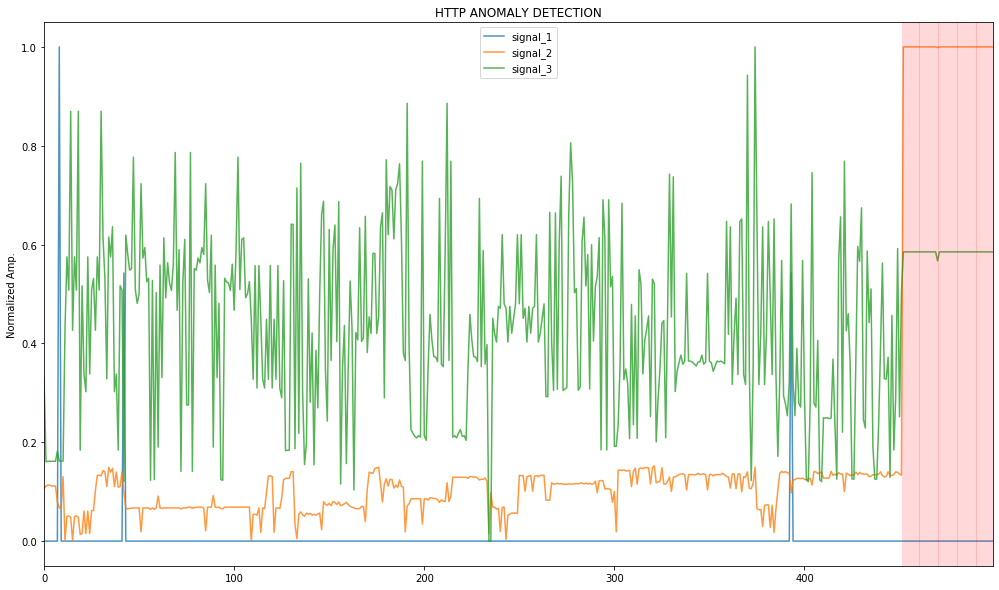

In [12]:
title='HTTP ANOMALY DETECTION'
ylabel='Normalized Amp.'
xlabel='' # we don't really need a label here
#SMTP
# min_lim = 3650
# max_lim = 3800
#HTTP
min_lim = 0
max_lim = 500
df_y = df_y[min_lim:max_lim]
ax = X_new_df[min_lim:max_lim].plot(figsize=(17,10),stacked=False,alpha=0.8,title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_y.query('labels==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='r',alpha=0.2);

In [13]:
final_scores = StreamingHSTrees(X_new, 250, 25, 15)


Score is 222826200.000000 for instance 0
Score is 218167536.000000 for instance 1
Score is 215075056.000000 for instance 2
Score is 215075056.000000 for instance 3
Score is 218167536.000000 for instance 4
Score is 218167536.000000 for instance 5
Score is 218167536.000000 for instance 6
Score is 231711216.000000 for instance 7
Score is 45835120.000000 for instance 8
Score is 229451504.000000 for instance 9
Score is 213874928.000000 for instance 10
Score is 210384384.000000 for instance 11
Score is 228360808.000000 for instance 12
Score is 232341352.000000 for instance 13
Score is 177276840.000000 for instance 14
Score is 210384384.000000 for instance 15
Score is 228360808.000000 for instance 16
Score is 232341352.000000 for instance 17
Score is 177276840.000000 for instance 18
Score is 201139336.000000 for instance 19
Score is 213424232.000000 for instance 20
Score is 230780120.000000 for instance 21
Score is 201131512.000000 for instance 22
Score is 232310576.000000 for instance 23
Sco

Score is 236629864.000000 for instance 238
Score is 238450512.000000 for instance 239
Score is 213391272.000000 for instance 240
Score is 238008816.000000 for instance 241
Score is 238483280.000000 for instance 242
Score is 212981672.000000 for instance 243
Score is 230940928.000000 for instance 244
Score is 225929448.000000 for instance 245
Score is 235281256.000000 for instance 246
Score is 236082536.000000 for instance 247
Score is 229422928.000000 for instance 248
Score is 228948464.000000 for instance 249
Reset tree
Score is 219338576.000000 for instance 250
Score is 218864112.000000 for instance 251
Score is 223389544.000000 for instance 252
Score is 229162256.000000 for instance 253
Score is 221708648.000000 for instance 254
Score is 219305808.000000 for instance 255
Score is 222588264.000000 for instance 256
Score is 229162256.000000 for instance 257
Score is 219305808.000000 for instance 258
Score is 218864112.000000 for instance 259
Score is 221708648.000000 for instance 260


Score is 57385940.000000 for instance 479
Score is 57385940.000000 for instance 480
Score is 57385940.000000 for instance 481
Score is 57385940.000000 for instance 482
Score is 57385940.000000 for instance 483
Score is 57385940.000000 for instance 484
Score is 57385940.000000 for instance 485
Score is 57385940.000000 for instance 486
Score is 57385940.000000 for instance 487
Score is 57385940.000000 for instance 488
Score is 57385940.000000 for instance 489
Score is 57385940.000000 for instance 490
Score is 57385940.000000 for instance 491
Score is 57385940.000000 for instance 492
Score is 57385940.000000 for instance 493
Score is 57385940.000000 for instance 494
Score is 57385940.000000 for instance 495
Score is 57385940.000000 for instance 496
Score is 57385940.000000 for instance 497
Score is 57385940.000000 for instance 498
Score is 57385940.000000 for instance 499
Reset tree


In [14]:
accuracy_value(final_scores, y, anomalies_number)

tp: 45, fp: 3,tn: 449, fn: 3, tpr: 0.937500, fpr: 0.006637, precision: 0.937500, recall: 0.937500
